In [23]:
import pandas as pd
from statsmodels.tsa.stattools import coint
import seaborn as sns
import matplotlib.pyplot as plt

# load CSV
data = pd.read_csv("ARM_NVDA_TSM.csv", parse_dates=['time'], dayfirst=True).set_index('time')

In [25]:
data

,ARM,NVDA,TSM
time,,,
2023-09-14,63.59,45.56,89.85
2023-09-15,60.75,43.88,87.67
2023-09-18,58.00,43.95,87.26
2023-09-19,55.17,43.50,86.61
2023-09-20,52.91,42.22,85.75
...,...,...,...
2025-03-17,121.37,119.53,175.70
2025-03-18,119.72,115.43,173.13
2025-03-19,117.91,117.52,173.76


In [27]:
# fn Cointegration
def get_pvalues(df):
    tickers = df.columns
    p_values = pd.DataFrame(index=tickers, columns=tickers)
    
    for i in range(len(tickers)):
        for j in range(i+1, len(tickers)):
            _, p_value, _ = coint(df[tickers[i]], df[tickers[j]])
            p_values.loc[tickers[i], tickers[j]] = p_value
            p_values.loc[tickers[j], tickers[i]] = p_value  # ทำให้สมมาตร
    return p_values

# P-value
p_values = get_pvalues(data)

In [29]:
p_values

,ARM,NVDA,TSM
ARM,NaN,0.138989,0.258629
NVDA,0.138989,NaN,0.266239
TSM,0.258629,0.266239,NaN


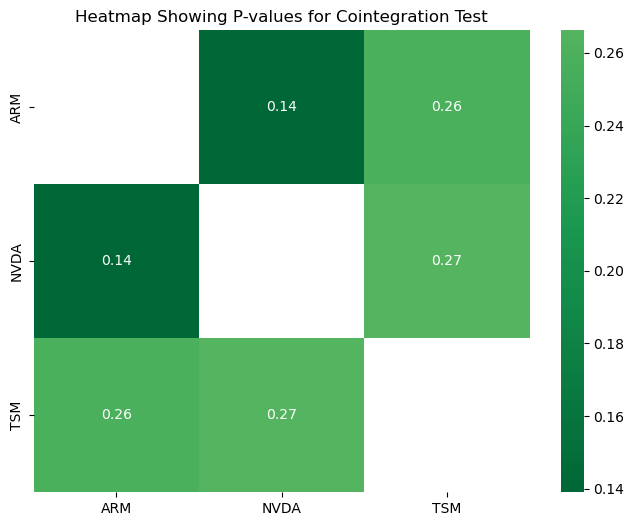

In [31]:
# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(p_values.astype(float), annot=True, cmap='RdYlGn_r', center=0.5)
plt.title('Heatmap Showing P-values for Cointegration Test')
plt.show()

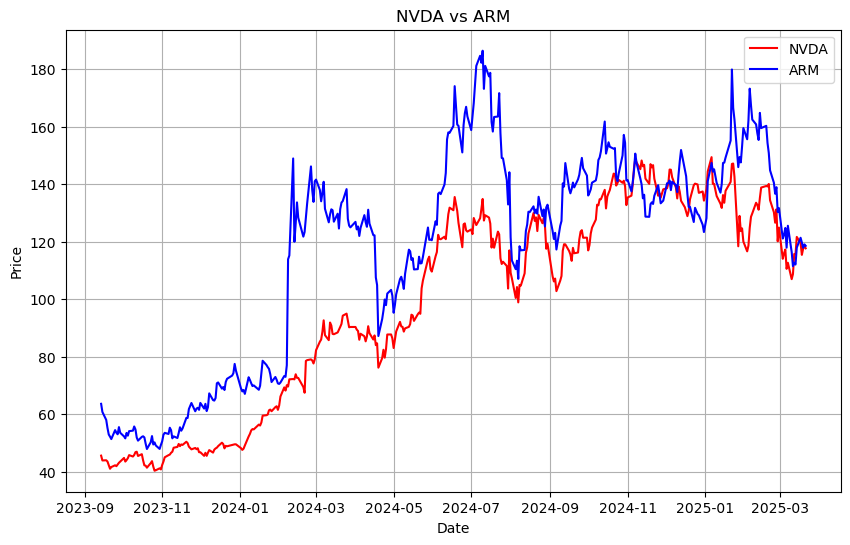

In [37]:
# price
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['NVDA'], label='NVDA', color='red')
plt.plot(data.index, data['ARM'], label='ARM', color='blue')

# เพิ่มเส้นอธิบาย
plt.legend()
plt.title('NVDA vs ARM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

plt.show()


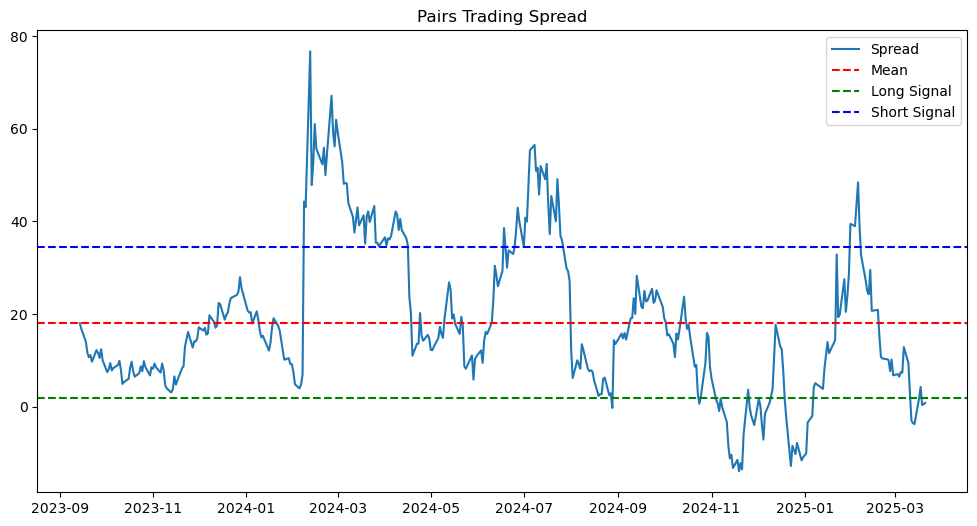

In [39]:
# Spread calculation
data['spread'] = data['ARM'] - data['NVDA']

# Trading signals
data['long_signal'] = data['spread'] < data['spread'].mean() - data['spread'].std()
data['short_signal'] = data['spread'] > data['spread'].mean() + data['spread'].std()

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(data['spread'], label='Spread')
plt.axhline(data['spread'].mean(), color='red', linestyle='--', label='Mean')
plt.axhline(data['spread'].mean() - data['spread'].std(), color='green', linestyle='--', label='Long Signal')
plt.axhline(data['spread'].mean() + data['spread'].std(), color='blue', linestyle='--', label='Short Signal')
plt.legend()
plt.title('Pairs Trading Spread')
plt.show()


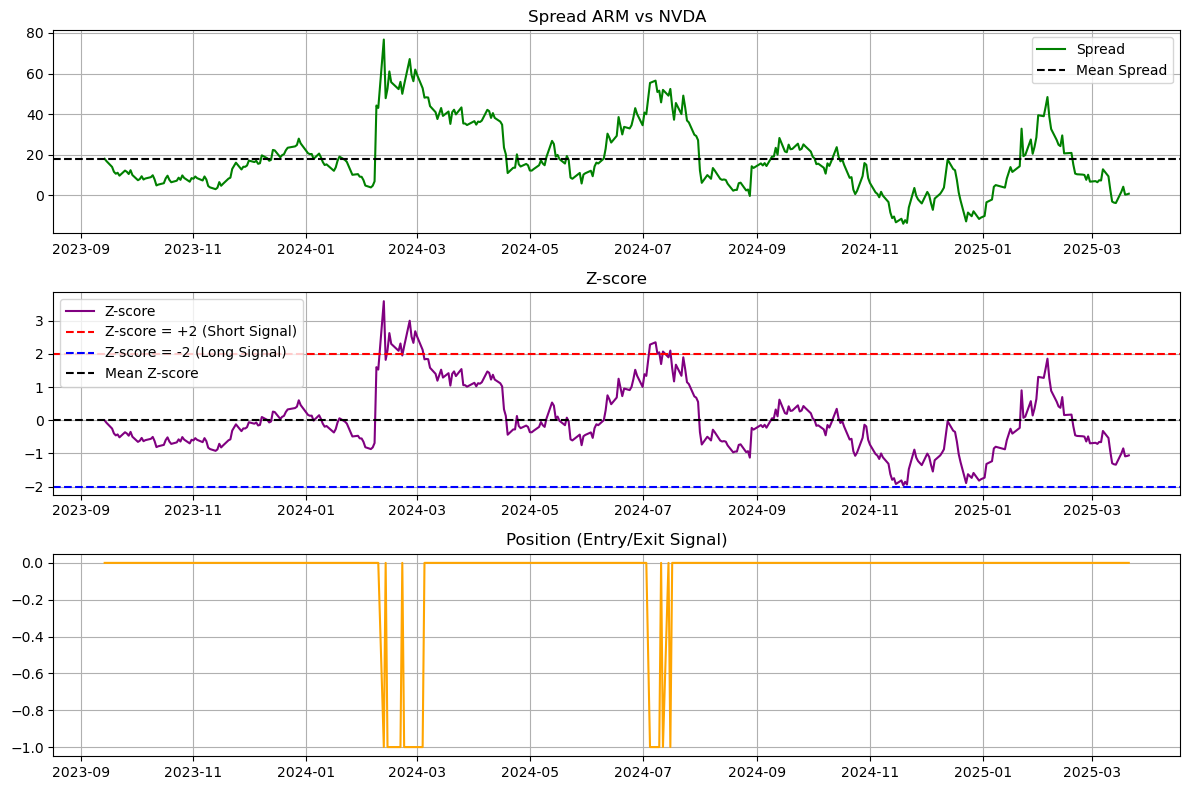

In [57]:
# Spread calculation
data['Spread'] = data['ARM'] - data['NVDA']

# Calculate Mean and Std
mean_spread = data['Spread'].mean()
std_spread = data['Spread'].std()

# Z-score
data['Zscore'] = (data['Spread'] - mean_spread) / std_spread

# Trading signals
data['Position'] = np.where(data['Zscore'] > 2, -1, 0)  # Short Spread
data['Position'] = np.where(data['Zscore'] < -2, 1, data['Position'])  # Long Spread

plt.figure(figsize=(12, 8))

# Spread
plt.subplot(3, 1, 1)
plt.plot(data.index, data['Spread'], label='Spread', color='green')
plt.axhline(mean_spread, color='black', linestyle='--', label='Mean Spread')
plt.title('Spread ARM vs NVDA')
plt.legend()
plt.grid(True)

# Z-score
plt.subplot(3, 1, 2)
plt.plot(data.index, data['Zscore'], label='Z-score', color='purple')
plt.axhline(2, color='red', linestyle='--', label='Z-score = +2 (Short Signal)')
plt.axhline(-2, color='blue', linestyle='--', label='Z-score = -2 (Long Signal)')
plt.axhline(0, color='black', linestyle='--', label='Mean Z-score')
plt.title('Z-score')
plt.legend()
plt.grid(True)

# Position
plt.subplot(3, 1, 3)
plt.plot(data.index, data['Position'], label='Position', color='orange')
plt.title('Position (Entry/Exit Signal)')
plt.grid(True)

plt.tight_layout()
plt.show()